In [14]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [37]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using JuMP
using COSMO
using Printf

In [29]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [30]:
#Quadrotor parameters
m = 0.5
ℓ = 0.1750
J = Diagonal([0.0023, 0.0023, 0.004])
g = 9.81
kt=1.0
km=0.0245

h = 0.05 #20 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

# Cost weights
Q = Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 0.1; 0.1; 0.1]);
R = Array(I(Nu));

In [31]:
#Goal state
uhover = (m*g/4)*ones(4)
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [32]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [33]:
#LQR Controller
# K = dlqr(Ã,B̃,Q,R)
#Feedback controller
function controller_lqr(x, k)
    
  q0 = x0[4:7]
  q = x[4:7]
  ϕ = qtorp(L(q0)'*q)
  
  Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
  
  u = uhover - K*Δx̃
end

controller_lqr (generic function with 1 method)

In [ ]:
A

ΔJ = 8.526512829121202e-14
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    8.275e+01   8.53e-14   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 2.7771877818700517e-7


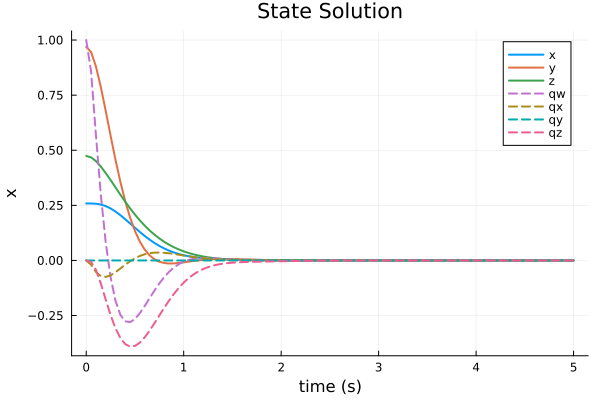

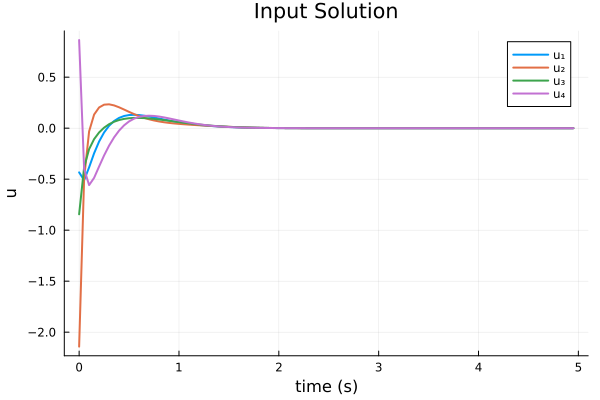

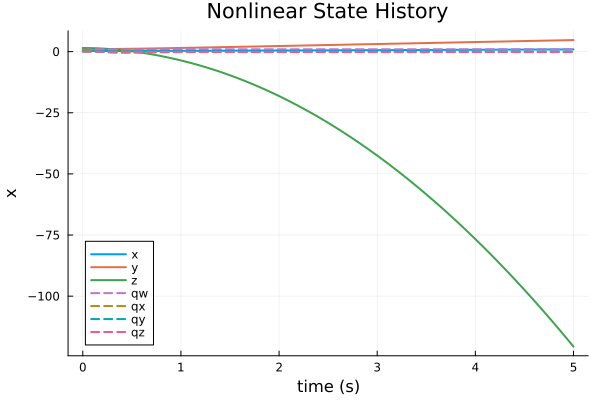

In [38]:
#Feedback hovering controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

Δx̃g = zeros(nx)
Xref = [deepcopy(Δx̃g) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

u_min = -1*uhover
u_max =  0.8*uhover

x_min = -100.0*ones(nx)
x_min[1:7] .= -.8
x_max = 100.0*ones(nx)
x_max[1:7] .= 1.0

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*1
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Xref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [ones(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

Random.seed!(12);
x = [rg+rand(3); L(qg)*rptoq([1; 0; 0]); vg; ωg];
q = x[4:7]
ϕ = qtorp(L(qg)'*q)    
Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
X[1] .= Δx̃
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))             

ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    1.113e+05   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0


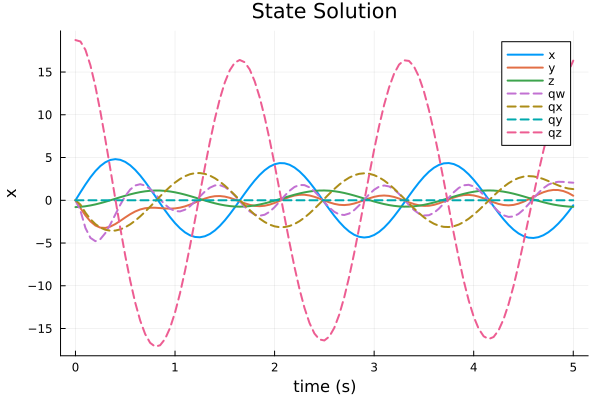

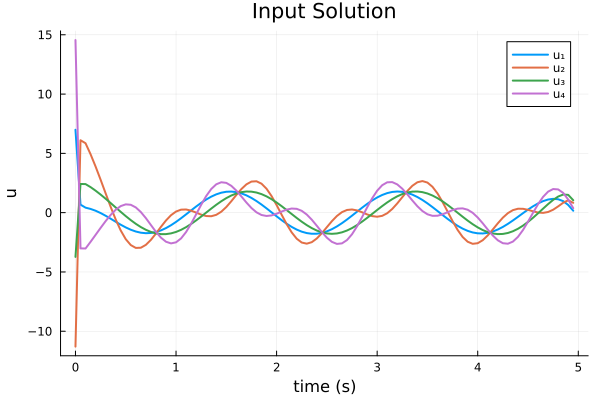

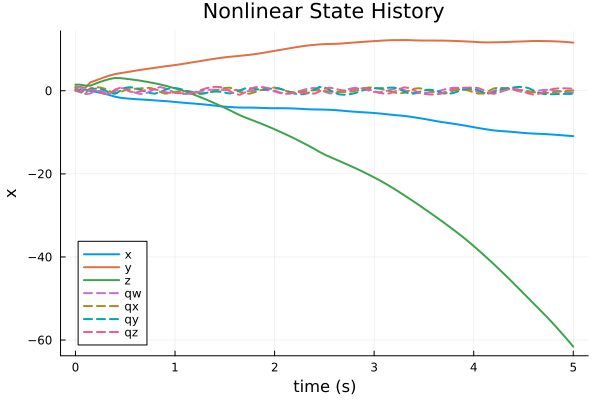

In [40]:
#Feedback tracking controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:Nt]
Uref = [zeros(nu) for i = 1:Nt-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1.2+sin(t);1;zeros(9)] for t = range(-pi/2, 3*pi/2 + 4*pi, length = Nt)]
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    rref = Xref[k][1:3]
    qref = Xref[k][4:7]
    vref = Xref[k][8:10]
    ωref = Xref[k][10:12]
    ϕ = qtorp(L(qg)'*qref)    
    Δx̃ref[k] .= [-xg[1:3]+rref; ϕ; -xg[8:10]+vref; -xg[11:13]+ωref]
end
u_min = -uhover
u_max =  0.8*uhover

# state is x y v θ
x_min = -ones(nx)
x_max = ones(nx)

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

X[1] .= Δx̃ref[1]
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))   

In [239]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
nx = Nx̃
nu = Nu
N = 41
dt = h
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt+N]
Δx̃ref = [zeros(nx) for i = 1:Nt+N]
Uref = [zeros(nu) for i = 1:Nt+N-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1;1;zeros(9)] for t = range(0, 2*pi + pi/4, length = Nt+N)]  # Number-eight
Xref = [[0.1*t;0.1*t;1;1;zeros(9)] for t = 1:Nt+N]  # Straight
scale = 40.0; a = 3; b = 3;
for k = 1:Nt+N  # Triangle
    if k < (Nt+N)/3
        Xref[k][1:2] .= [a*k; b*k]/scale
    elseif k < 2*(Nt+N)/3
        k1 = k - (Nt+N)/3
        Xref[k][1:2] .= [a*(Nt+N)/3 + a*k1; b*(Nt+N)/3 - b*k1]/scale
    else 
        k1 = k - 2*(Nt+N)/3
        Xref[k][1:2] .= [a*(Nt+N)/3 - a*k1; 0.0]/scale
    end
end
for i = 1:Nt+N-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt+N
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -1*uhover
u_max =  1*uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.3
x_max = 100*ones(nx)
x_max[3] = 0.3

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);
optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "rho"=>1e-2,
        "scaling"=>0,
        "alpha"=>1.0)
# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)
    
P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    u = mpc_JuMP(optimizers, params, X, U, Ã, B̃, 0.0; warm_start=false)
    # u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=20,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0)
    return u + uhover
end

controller_mpc (generic function with 1 method)

In [240]:
#Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3); L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
# xhist[1] .= Xref[1]
xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*1
for k = 1:(Nt-1)
    params1 = (; params..., Uref = Uref[k:N+k-1], Xref = Δx̃ref[k:N+k])  # update ref
    uhist[k] = controller_mpc(params1, xhist[k], k)
    # uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

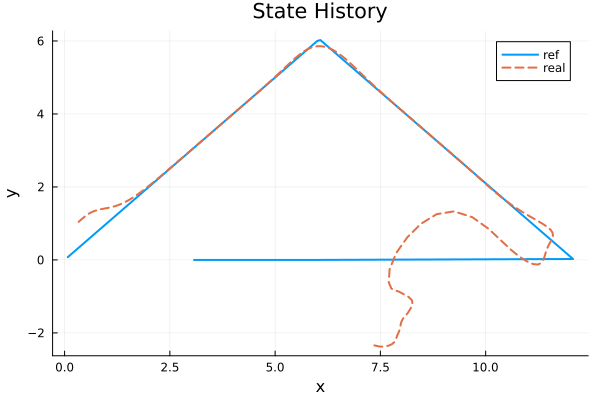

In [241]:
Xsim_m = mat_from_vec(Xref[1:Nt])
plot(Xsim_m[1,:],Xsim_m[2,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="x", ylabel="y")
Xsim_m = mat_from_vec(xhist[1:Nt])   
display(plot!(Xsim_m[1,:],Xsim_m[2,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="x", ylabel="y"))

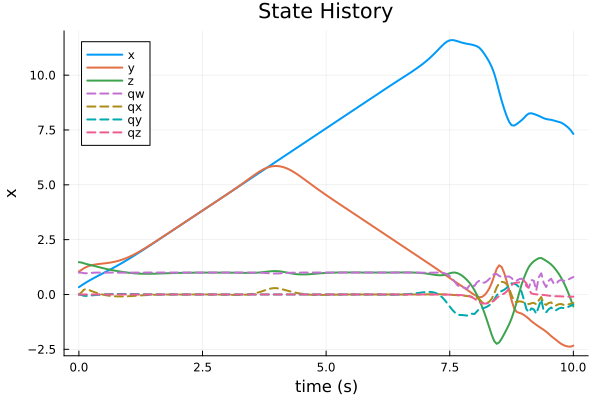

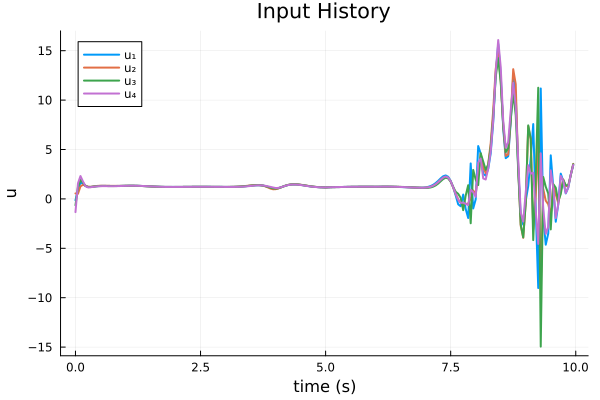

In [242]:
Xsim_m = mat_from_vec(xhist[1:Nt])   
Usim_m = mat_from_vec(uhist[1:Nt-1])   
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [94]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8704))

In [95]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [209]:
X1 = [SVector{13}(x) for x in xhist];
visualize!(vis, model, t_vec[end], X1)